In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import pickle
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from trackml.utils import add_position_quantities, add_momentum_quantities
import math
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'trackml'

In [2]:
model = tf.keras.models.load_model('trained_models/Extrap_RNN_windowSize3', compile=False)

2022-04-26 14:34:31.281564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:34:31.312840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:34:31.313071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:34:31.313680: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
def get_theta(r, z):
    if z == 0:
        return 0

    sign = 1
    if z < 0:
        sign = -1
        z = abs(z)
    theta = math.atan(r/float(z))
    return theta

def displacement(true_hit, pred_hit):
    
    x_true = true_hit[0]
    y_true = true_hit[1]
    z_true = true_hit[2]
    
    x_pred = pred_hit[0]
    y_pred = pred_hit[1]
    z_pred = pred_hit[2]
    
    return np.sqrt((x_true - x_pred)**2 + (y_true-y_pred)**2 + (z_true-z_pred)**2)

In [4]:
def dataWindow(window_size, tracks, layer_info, pt, n_features=3):
    #Input (tracks) should be an array of shape (n_samples, n_hits*n_features where the features are listed as x0, y0, z0, x1, y2, z2, ...)
    # returns an x array of size (n_samples, window_size, n_features)
    # returns a y array of size (n_samples, n_features)
    seeds = {}
    targets = {}
    pts = []
    track_list = []
    trackSeed_idx = []
    track_idx = 0 
    #for i in range(1):
    for i in range(tracks.shape[0]):
        detector_layers = layer_info.iloc[i][15:]
        detector_volumes = layer_info.iloc[i][0:15]
        track = tracks[i]
        x=track[0:15]
        y=track[15:30]
        z=track[30:]
        new_track = None
        prev_layer_id = -999
        prev_volume_id = -999
        for j in range(15):
            layer_id = detector_layers[j]
            volume_id = detector_volumes[j]
            
            # if the hit is in the same volume as the previous hit, ensure it is in the next consecutive layer
            if volume_id == prev_volume_id:
                if layer_id == prev_layer_id +1:
                    hit = np.array([x[j], y[j], z[j]])
                    if np.any(hit) == 0: break
                    prev_layer_id = layer_id
                    if np.any(new_track) is None: 
                        new_track = hit
                    else: 
                        new_track = np.vstack([new_track,hit])
                else: continue
                    
            else: 
                hit = np.array([x[j], y[j], z[j]])
                if np.any(hit) == 0: break
                prev_layer_id = layer_id
                prev_volume_id = volume_id
                if np.any(new_track) is None: 
                    new_track = hit
                else: 
                    new_track = np.vstack([new_track,hit])
            
        if len(new_track) > window_size+1:
            track_list.append(track)
        else:
            continue
        
        seeds[i] = None
        targets[i] = None
        n_hits = new_track.shape[0]
        
        for w in range(n_hits - window_size):
            seed = new_track[w:w+window_size]
            target = new_track[w+window_size]
            
            if seeds[i] is None:
                seeds[i] = seed
                targets[i] = target
            else:
                seeds[i] = np.append(seeds[i], seed, axis=0)
                targets[i] = np.append(targets[i], target, axis=0)
            pts.append(pt[i])
            trackSeed_idx.append(track_idx)
        track_idx += 1
    
    x = None
    y = None
    for key in seeds.keys():
        if x is None:
            x = seeds[key]
            y = targets[key]
        else:
            x = np.append(x, seeds[key])
            y = np.append(y, targets[key])


    return x.reshape(-1,window_size,3), y.reshape(-1,3), pts

In [7]:
filepath = 'local_data/extrapData/ACTS_SingleMu_0.pkl'
with open(filepath, 'rb') as pFile:
    _ = pickle.load(pFile, encoding='latin1')
    _ = pickle.load(pFile, encoding='latin1')

    x_train = pickle.load(pFile, encoding='latin1')
    x_test = pickle.load(pFile,  encoding='latin1')
    x_train_flat = pickle.load(pFile,  encoding='latin1')
    x_test_flat = pickle.load(pFile,  encoding='latin1')
    x_train_layer = pickle.load(pFile,  encoding='latin1')
    x_test_layer = pickle.load(pFile,  encoding='latin1')

    _ = pickle.load(pFile,  encoding='latin1')
    _ =  pickle.load(pFile,  encoding='latin1')
    _ = pickle.load(pFile,  encoding='latin1')
    _ = pickle.load(pFile,  encoding='latin1')

    y_train = pickle.load(pFile,  encoding='latin1')
    y_test = pickle.load(pFile,  encoding='latin1')

    _ = pickle.load(pFile,  encoding='latin1')
    _ = pickle.load(pFile,  encoding='latin1')

    pt_train = pickle.load(pFile,  encoding='latin1')
    pt_test = pickle.load(pFile,  encoding='latin1')

# x_data, y_data, pt_data = dataWindow(3, x_train_flat, x_train_layer, pt_train)
# x_data_test, y_data_test, pt_data_test = dataWindow(3, x_test_flat, x_test_layer, pt_test)

In [15]:
x_train_layer.layerID0.unique()

array([2, 8, 6, 4], dtype=int32)

In [141]:
x = None
y = None
filepath = 'local_data/extrapData/ACTS_SingleMu_0.pkl'
for f in os.listdir(filepath)[5:6]:
    if not "ACTS" in f: continue
    print(f)
    with open(filepath+f, 'rb') as pFile:
            _ = pickle.load(pFile, encoding='latin1')
            _ = pickle.load(pFile, encoding='latin1')

            x_train = pickle.load(pFile, encoding='latin1')
            x_test = pickle.load(pFile,  encoding='latin1')
            x_train_flat = pickle.load(pFile,  encoding='latin1')
            x_test_flat = pickle.load(pFile,  encoding='latin1')
            x_train_layer = pickle.load(pFile,  encoding='latin1')
            x_test_layer = pickle.load(pFile,  encoding='latin1')

            _ = pickle.load(pFile,  encoding='latin1')
            _ =  pickle.load(pFile,  encoding='latin1')
            _ = pickle.load(pFile,  encoding='latin1')
            _ = pickle.load(pFile,  encoding='latin1')

            y_train = pickle.load(pFile,  encoding='latin1')
            y_test = pickle.load(pFile,  encoding='latin1')
            
            _ = pickle.load(pFile,  encoding='latin1')
            _ = pickle.load(pFile,  encoding='latin1')
            
            pt_train = pickle.load(pFile,  encoding='latin1')
            pt_test = pickle.load(pFile,  encoding='latin1')
            
    x_data, y_data, pt_data = dataWindow(3, x_train_flat, x_train_layer, pt_train)
    x_data_test, y_data_test, pt_data_test = dataWindow(3, x_test_flat, x_test_layer, pt_test)

    if x is None:
        x = x_data
        y = y_data
        pt = pt_data
        x = np.append(x, x_data_test, axis=0)
        y = np.append(y, y_data_test, axis=0)
        pt = np.append(pt, pt_data_test, axis=0)
    else:
        x = np.append(x, x_data, axis=0)
        y = np.append(y, y_data, axis=0)
        pt = np.append(pt, pt_data, axis=0)
        x = np.append(x, x_data_test, axis=0)
        y = np.append(y, y_data_test, axis=0)
        pt = np.append(pt, pt_data_test, axis=0)

Athena_ttbar_mu200_10.pkl


In [6]:
xPhi = np.arctan2(x[:,:,1].flatten(), x[:,:,0].flatten()) / np.pi
xPhi = xPhi.reshape(-1,3,1)
x_cyl = np.append(xPhi, x[:,:,2].reshape(-1,3,1), axis=2)
del xPhi
yPhi = np.arctan2(y[:,1].flatten(), y[:,0].flatten()).reshape(-1,1)
y_cyl = np.append(yPhi, y[:,2].reshape(-1,1), axis=1)
del yPhi

In [ ]:
fig = plt.figure(figsize=(14,10))
plt.scatter(x[:,:,2]*3000, np.sqrt(x[:,:,0]**2+x[:,:,1]**2)*1015, s=.05, label='true')
plt.scatter(predictions[:,2], np.sqrt(predictions[:,0]**2+predictions[:,1]**2), s=.05, label='pred')
plt.legend()
plt.xlabel('z (mm)')
plt.ylabel(r'$\rho$ (mm)')
plt.savefig('fig.png')

In [203]:
def plotHitsInLayer(dframe, volume, layer, tracks):
    hitIdx = []
    x = np.array([])
    y = np.array([])
    z = np.array([])
    
    df = dframe.copy()
    df.reset_index(inplace=True)
    for i in range(0,15):
        lyr_col = df.columns[i+15]
        vol_col = df.columns[i]

        idx = df[(df[vol_col]==volume) & (df[lyr_col] == layer)].index
        x = np.append(x, tracks[idx][:, i])
        y = np.append(y, tracks[idx][:, i+15])
        z = np.append(z, tracks[idx][:, i+30])
    x = x*1015
    y = y*1015
    z = z*3000
    fig, axs = plt.subplots(2,1, figsize=(14,20))
    axs[0].scatter(x,y, s=.05)
    axs[0].set_xlim(-1200,1200)
    axs[0].set_ylim(-1200, 1200)
    axs[1].scatter(z, np.sqrt(x**2+y**2),s=.05)
    axs[1].set_xlim(-3000, 3000)
    axs[1].set_ylim(0, 1200)
    
    

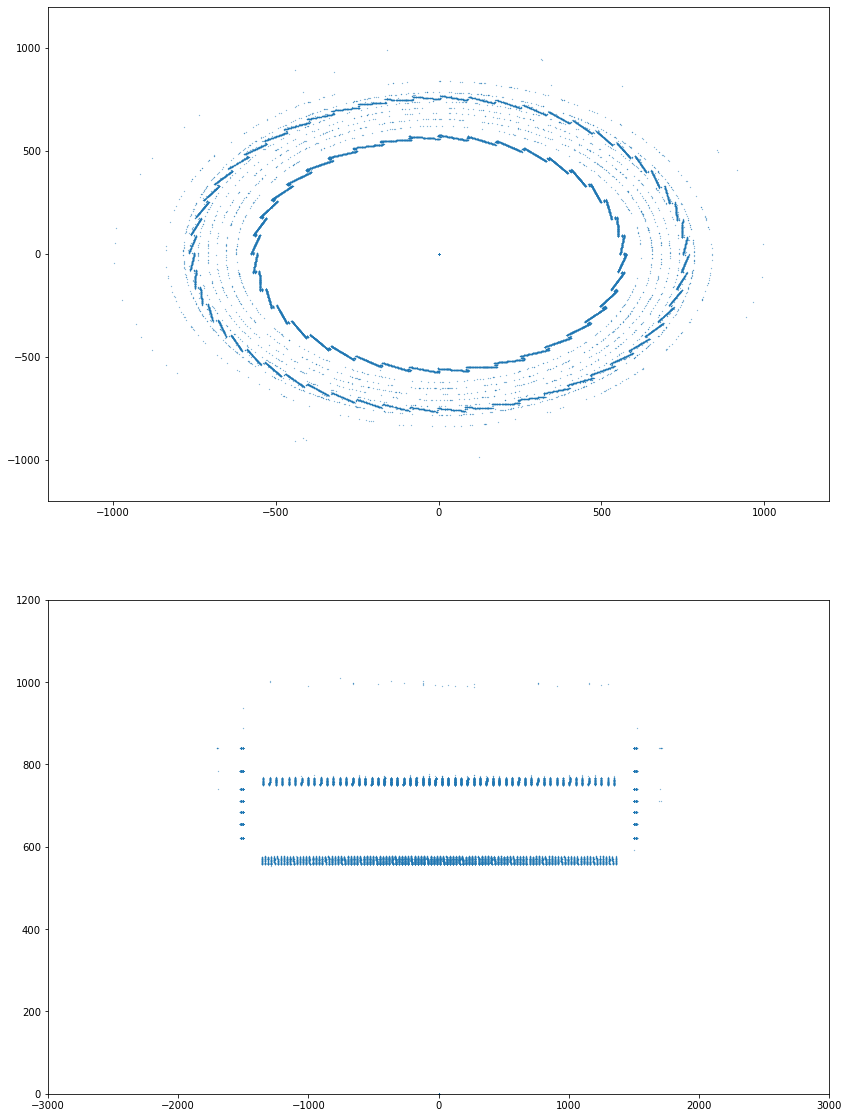

In [214]:
d = plotHitsInLayer(x_train_layer, 10, 1, x_train_flat)

Text(0, 0.5, '$\\rho$ (mm)')

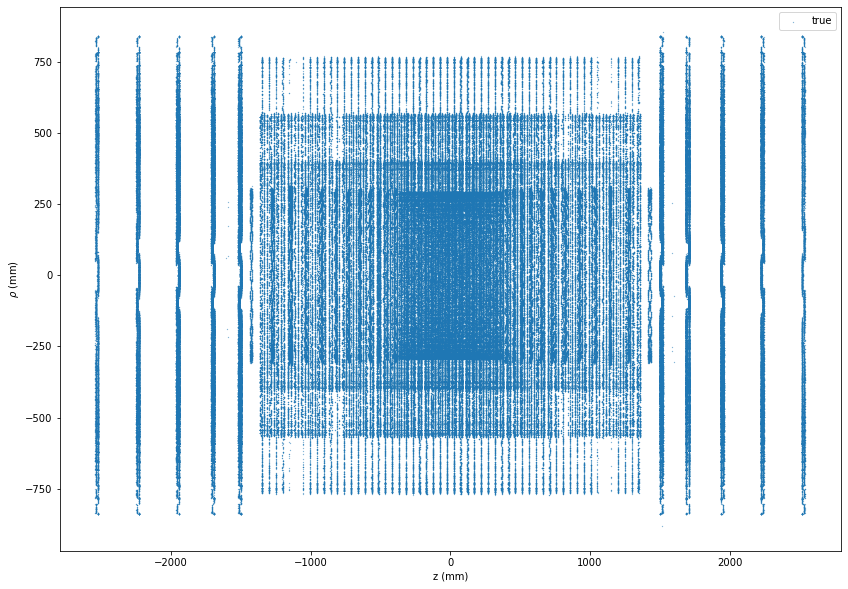

In [22]:
fig = plt.figure(figsize=(14,10))
plt.scatter(x[:,:,2]*3000,x[:,:,1]*1015, s=.05, label='true')
#plt.scatter(predictions[:,2], np.sqrt(predictions[:,0]**2+predictions[:,1]**2), s=.05, label='pred')
plt.legend()
plt.xlabel('z (mm)')
plt.ylabel(r'$\rho$ (mm)')
#plt.savefig('fig.png')

Text(0, 0.5, '$\\rho$ (mm)')

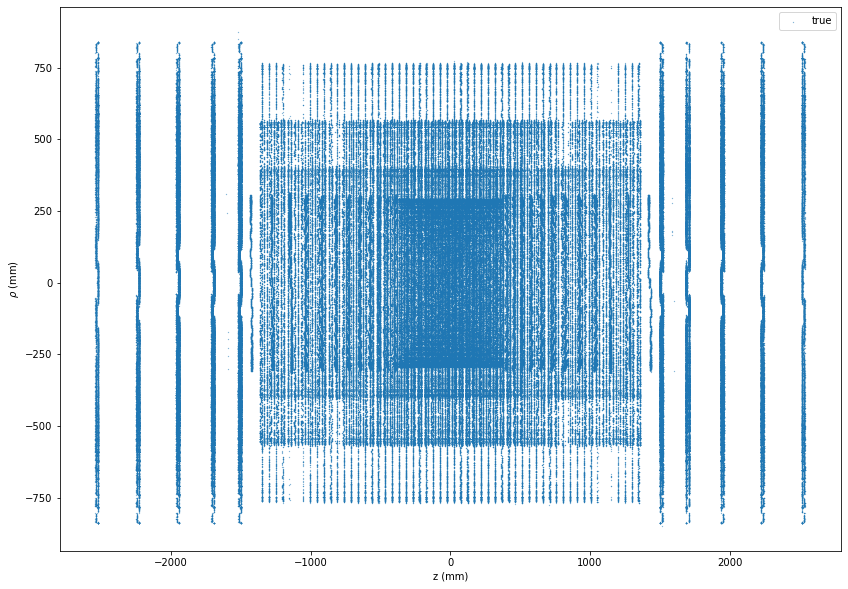

In [21]:
fig = plt.figure(figsize=(14,10))
plt.scatter(x[:,:,2]*3000,x[:,:,0]*1015, s=.05, label='true')
#plt.scatter(predictions[:,2], np.sqrt(predictions[:,0]**2+predictions[:,1]**2), s=.05, label='pred')
plt.legend()
plt.xlabel('z (mm)')
plt.ylabel(r'$\rho$ (mm)')
#plt.savefig('fig.png')

In [217]:
x

array([[[-0.2823036 , -0.09642613,  0.19191113],
        [-0.36940473, -0.11582893,  0.24088047],
        [-0.53491324, -0.14144158,  0.33104548]],

       [[-0.36940473, -0.11582893,  0.24088047],
        [-0.53491324, -0.14144158,  0.33104548],
        [-0.73812586, -0.15391916,  0.4332163 ]],

       [[ 0.24653536,  0.14099763, -0.10069139],
        [ 0.33123094,  0.20416434, -0.14303811],
        [ 0.45898446,  0.31687382, -0.20806752]],

       ...,

       [[-0.25351825,  0.28951362, -0.01257098],
        [-0.38321614,  0.40460923, -0.02821091],
        [-0.5328596 ,  0.5160474 , -0.05737046]],

       [[-0.21045083, -0.18987273, -0.04389839],
        [-0.29216674, -0.24927233, -0.06988448],
        [-0.43058714, -0.33537078, -0.11056215]],

       [[-0.29216674, -0.24927233, -0.06988448],
        [-0.43058714, -0.33537078, -0.11056215],
        [-0.6131764 , -0.4243628 , -0.1551817 ]]], dtype=float32)

(0.0, 1200.0)

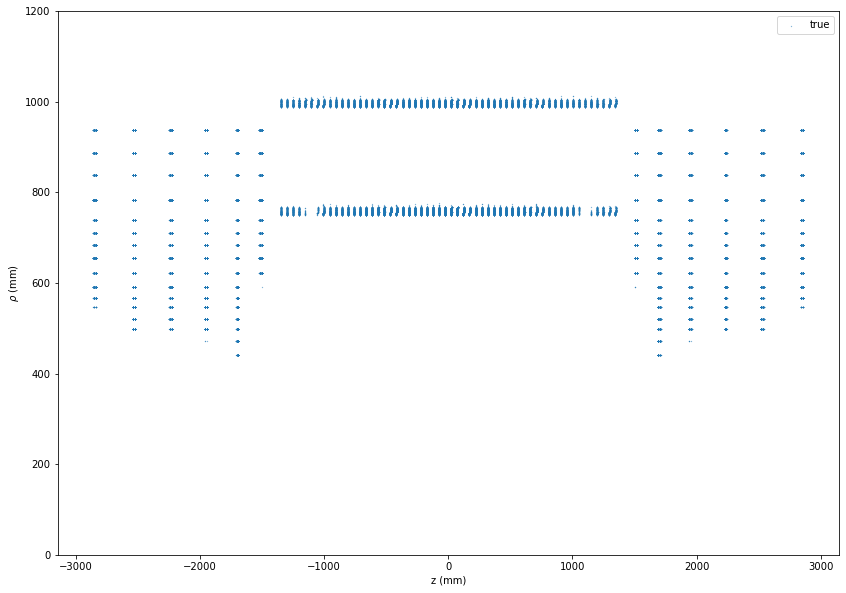

In [218]:
fig = plt.figure(figsize=(14,10))
plt.scatter(y[:,2]*3000, np.sqrt(y[:,0]**2+y[:,1]**2)*1015, s=.05, label='true')
#plt.scatter(predictions[:,2], np.sqrt(predictions[:,0]**2+predictions[:,1]**2), s=.05, label='pred')
plt.legend()
plt.xlabel('z (mm)')
plt.ylabel(r'$\rho$ (mm)')
plt.ylim(0,1200)
#plt.savefig('fig.png')

(0.0, 1200.0)

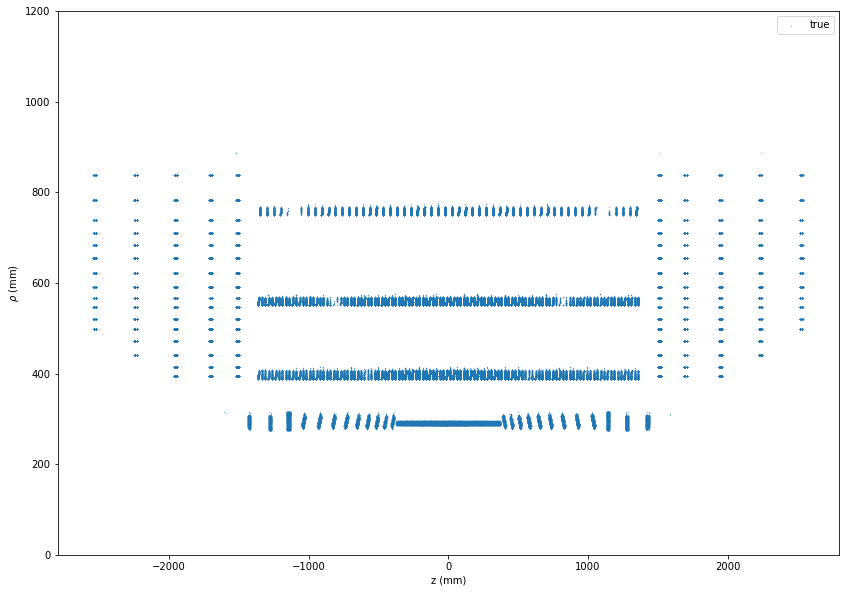

In [216]:
fig = plt.figure(figsize=(14,10))
plt.scatter(x[:,:,2]*3000, np.sqrt(x[:,:,0]**2+x[:,:,1]**2)*1015, s=.05, label='true')
#plt.scatter(predictions[:,2], np.sqrt(predictions[:,0]**2+predictions[:,1]**2), s=.05, label='pred')
plt.legend()
plt.xlabel('z (mm)')
plt.ylabel(r'$\rho$ (mm)')
plt.ylim(0,1200)
#plt.savefig('fig.png')

In [6]:
y[:,0] = y[:, 0]*1015
y[:,1] = y[:, 1]*1015
y[:,2] = y[:, 2]*3000

In [7]:
# plot displacement error as function of z, rho
predictions = model.predict(x)
predictions[:,0] = predictions[:, 0]*1015
predictions[:,1] = predictions[:, 1]*1015
predictions[:,2] = predictions[:, 2]*3000


y_rho = []
for ii in y:
    y_rho.append(np.sqrt(ii[0]**2 + ii[1]**2))
    
err = []
for i in range(len(predictions)):
    err.append(displacement(y[i], predictions[i]))

Text(0, 0.5, '$\\rho$ (mm)')

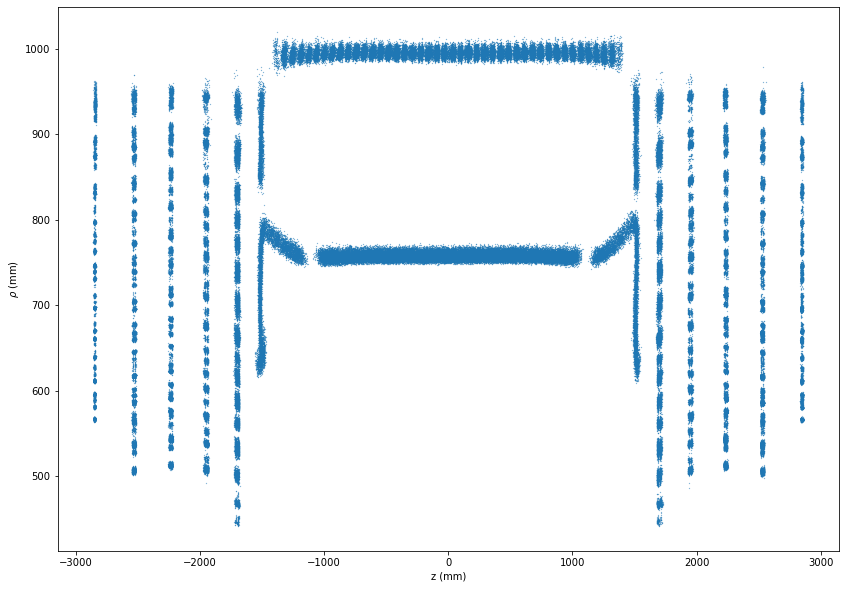

In [10]:
fig = plt.figure(figsize=(14,10))
plt.scatter(predictions[:,2], np.sqrt(predictions[:,0]**2+predictions[:,1]**2), s=.05)


plt.xlabel('z (mm)')
plt.ylabel(r'$\rho$ (mm)')

In [16]:
mse = tf.keras.losses.MeanSquaredError()
mse(y[:,2], predictions[:,2]).numpy()

288.5049

In [17]:
y[:,2]

array([1299.6489 , 1516.251  , -856.31836, ...,  515.77856,  417.3213 ,
        515.30164], dtype=float32)

In [18]:
predictions[:,2]

array([1345.0215 , 1499.6924 , -859.07434, ...,  527.93   ,  391.10318,
        527.93896], dtype=float32)

Text(0, 0.5, 'displacement (mm)')

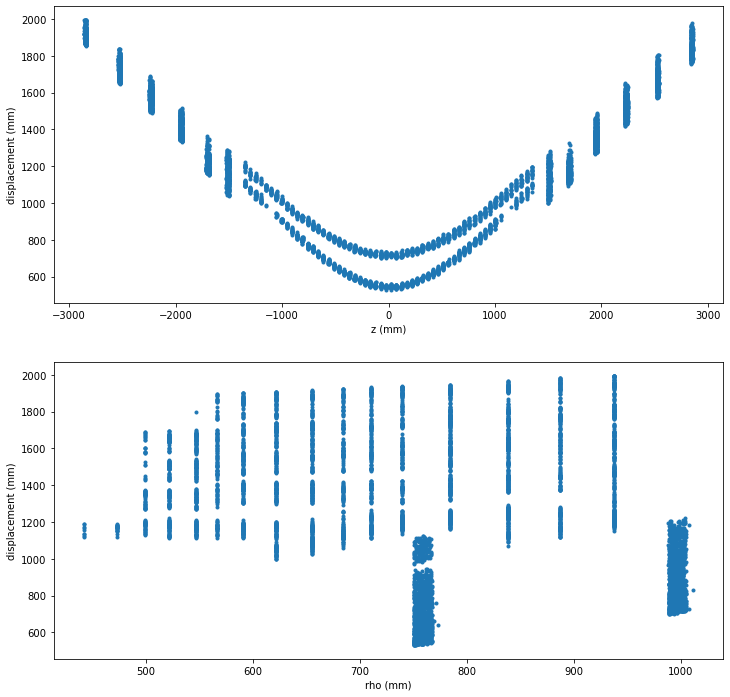

In [10]:
fig, axs = plt.subplots(2, figsize=(12,12))
axs[0].scatter(y[:,2], err, marker='.')
axs[0].set_xlabel('z (mm)')
axs[0].set_ylabel('displacement (mm)')
#axs[0].set_Yscale('log')

axs[1].scatter(y_rho, err, marker='.')
axs[1].set_xlabel('rho (mm)')
axs[1].set_ylabel('displacement (mm)')
#axs[1].set_Yscale('log')

NameError: name 'Y' is not defined

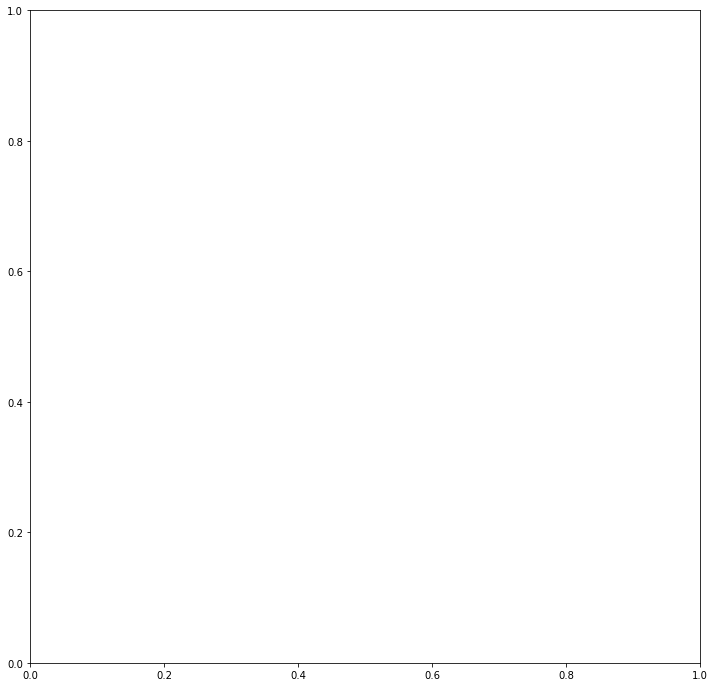

In [11]:
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='scatter_density')
density = ax.scatter_density(Y[:,2], err)
ax.set_xlabel('z (mm)')
ax.set_ylabel('displacement (mm)')
ax.set_ylim([0, 20])
ax.set_xlim([-1000, 1000])
fig.colorbar(density)
#axs[0].set_yscale('log')

# axs[1].scatter(y_rho, err, marker='.')
# axs[1].set_xlabel('rho (mm)')
# axs[1].set_ylabel('displacement (mm)')
# #axs[1].set_yscale('log')

In [ ]:
### -1<z<-.5 left endcap
### .5<z1 right endcap
### -.5<z<.5 barrel

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, coordinate='z', **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(10,10))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    #x += .1
    #y += .1
    #z += .1
    ax.scatter( x, y, c=z, **kwargs )
    ax.set_xlabel('{} (mm)'.format(coordinate))
    ax.set_ylabel('displacement error (mm)')
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    ax.set_ylim([0, 50])

    return ax, z

In [25]:
xt,yt = (y[:,2], np.array(err))
data , x_e, y_e = np.histogram2d( xt, yt,( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) bins = 20, density = True )
z = interpn(  , data , np.vstack([xt,yt]).T , method = "splinef2d", bounds_error = False)

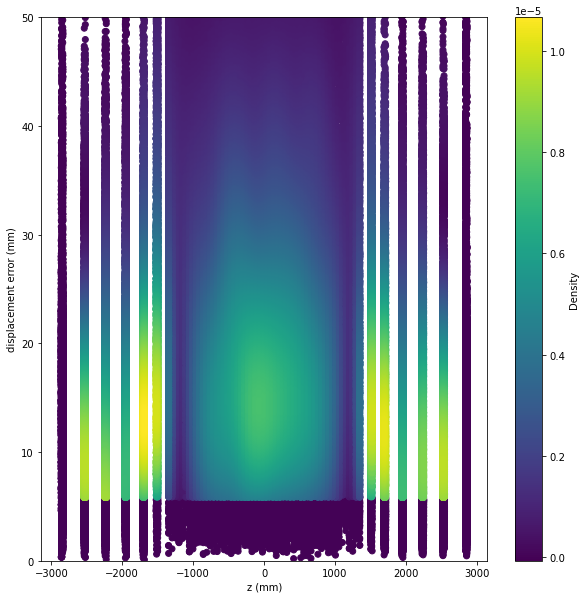

In [50]:
ax, z = density_scatter(y[:,2], np.array(err), sort=True)

(<AxesSubplot:xlabel='rho (mm)', ylabel='displacement error (mm)'>,
 array([4.53319375e-06, 1.25937865e-04, 5.85352306e-05, ...,
        0.00000000e+00, 2.43930752e-04, 7.41403573e-05]))

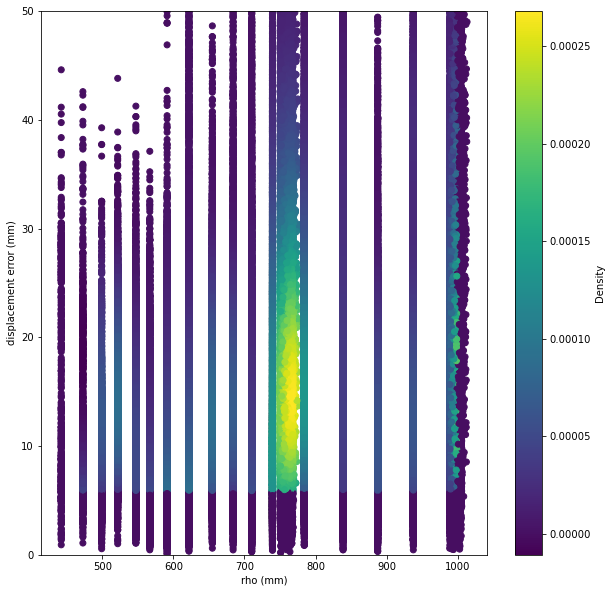

In [51]:
density_scatter(y_rho, err, sort=False, coordinate='rho')

In [ ]:
from scipy.stats import gaussian_kde

xy = np.vstack([y[:,2], np.array(err)])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.show()

In [8]:
y_pred_rho = []
for ii in predictions:
    y_pred_rho.append(np.sqrt(ii[0]**2 + ii[1]**2))

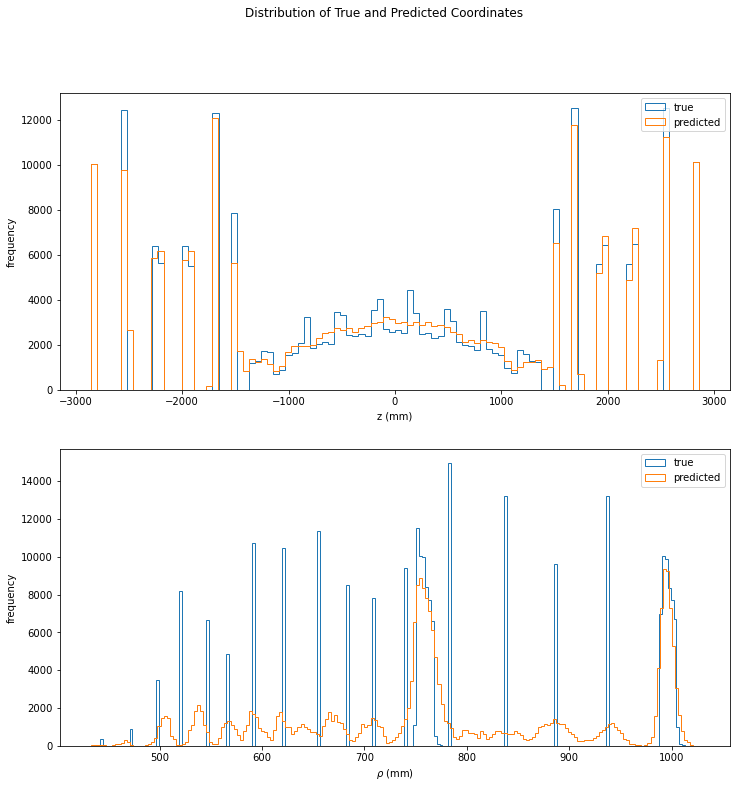

In [9]:
# plot distributions of predicted rho and z
fig, axs = plt.subplots(2, figsize=(12,12))
fig.suptitle('Distribution of True and Predicted Coordinates')

axs[0].hist(y[:,2], histtype='step', bins=100, label='true')
axs[0].hist(predictions[:,2], histtype='step', bins=100, label='predicted')
axs[0].set_xlabel('z (mm)')
axs[0].set_ylabel('frequency')
axs[0].legend();
#axs[0].set_yscale('log')


axs[1].hist(np.sqrt(y[:,0]**2+y[:,1]**2), histtype='step', bins=200, label='true')
axs[1].hist(np.sqrt(predictions[:,0]**2+predictions[:,1]**2), histtype='step', bins=200, label='predicted')
axs[1].set_xlabel(r'$\rho$ (mm)')
axs[1].set_ylabel('frequency')
axs[1].legend();
#axs[1].set_yscale('log')

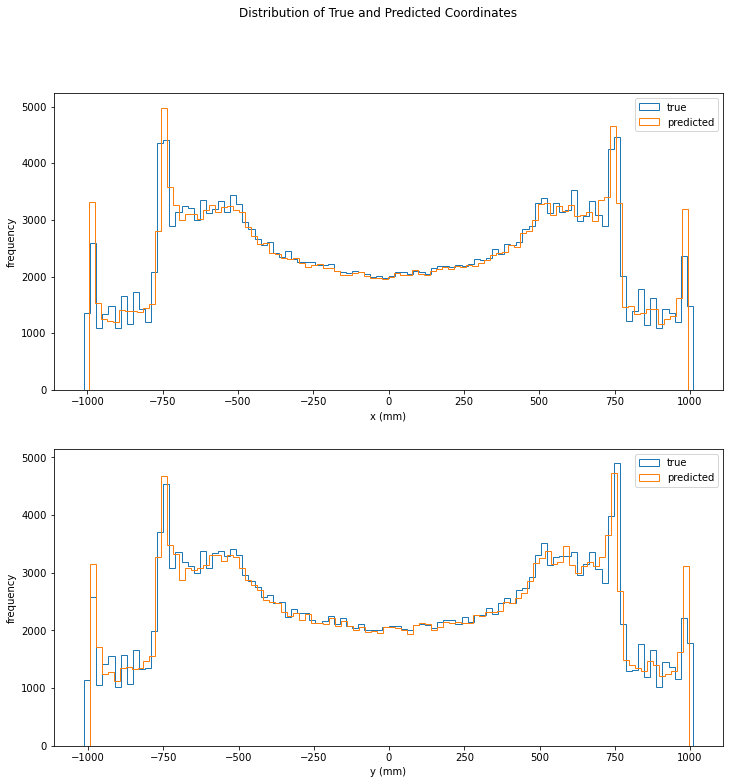

In [10]:
# plot distributions of predicted rho and z
fig, axs = plt.subplots(2, figsize=(12,12))
fig.suptitle('Distribution of True and Predicted Coordinates')

axs[0].hist(y[:,0], histtype='step', bins=100, label='true')
axs[0].hist(predictions[:,0], histtype='step', bins=100, label='predicted')
axs[0].set_xlabel('x (mm)')
axs[0].set_ylabel('frequency')
axs[0].legend();
#axs[0].set_yscale('log')


axs[1].hist(y[:,1], histtype='step', bins=100, label='true')
axs[1].hist(predictions[:,1], histtype='step', bins=100, label='predicted')
axs[1].set_xlabel('y (mm)')
axs[1].set_ylabel('frequency')
axs[1].legend();
#axs[1].set_yscale('log')

<ipython-input-11-b3be99aad32a>:1: RuntimeWarning: invalid value encountered in arcsin
  plt.hist(np.arcsin(y[:,1]/y[:,0]), histtype='step', bins=100, label='true')
<ipython-input-11-b3be99aad32a>:2: RuntimeWarning: invalid value encountered in arcsin
  plt.hist(np.arcsin(predictions[:,1]/predictions[:,0]), histtype='step', bins=100, label='predicted')


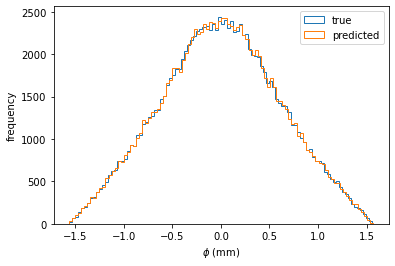

In [11]:
plt.hist(np.arcsin(y[:,1]/y[:,0]), histtype='step', bins=100, label='true')
plt.hist(np.arcsin(predictions[:,1]/predictions[:,0]), histtype='step', bins=100, label='predicted')
plt.xlabel(r'$\phi$ (mm)')
plt.ylabel('frequency')
plt.legend();
#axs[1].set_yscale('log')

<ipython-input-33-6c324de4b916>:1: RuntimeWarning: invalid value encountered in arcsin
  plt.hist(np.arcsin(y[:,1]/y[:,0])-np.arcsin(predictions[:,1]/predictions[:,0]), histtype='step', bins=300)
No handles with labels found to put in legend.


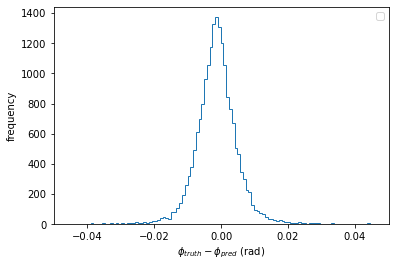

In [33]:
plt.hist(np.arcsin(y[:,1]/y[:,0])-np.arcsin(predictions[:,1]/predictions[:,0]), histtype='step', bins=300)
plt.xlabel(r'$\phi_{truth} - \phi_{pred} $ (rad)')
plt.ylabel('frequency')
plt.xlim([-.05, .05])
plt.legend();
#axs[1].set_yscale('log')

In [34]:
#Plot the distribution of angles between predictions and truth
angles = []
for p in range(len(y)):
    norm_a = np.linalg.norm(y[p])
    norm_b = np.linalg.norm(predictions[p])
    angle = np.dot(y[p], predictions[p]) / (norm_a * norm_b)
    angle = np.arccos(angle)
    angles.append(angle)
angles = np.array(angles)

<ipython-input-34-0d5cb1610c0e>:7: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(angle)


Text(0.5, 0, 'angle between predicted and true hits (rads)')

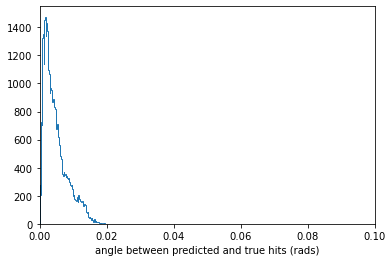

In [35]:
plt.hist(angles, bins=100, histtype='step');
plt.xlim([0,.1])
plt.xlabel('angle between predicted and true hits (rads)')

In [36]:
angles

array([0.00995308, 0.00986888, 0.00958081, ..., 0.00946816, 0.00527028,
       0.00146484], dtype=float32)

In [37]:
import math
res = []
for i in range(len(y)):
    deltaPhi = np.arcsin(y[i,1]/y[i,0])-np.arcsin(predictions[i,1]/predictions[i,0])
    if math.isnan(deltaPhi): continue
    res.append(deltaPhi)
np.std(res)

<ipython-input-37-352bebe72ec2>:4: RuntimeWarning: invalid value encountered in arcsin
  deltaPhi = np.arcsin(y[i,1]/y[i,0])-np.arcsin(predictions[i,1]/predictions[i,0])


0.007956336

In [109]:
# Plot the number of hits in an event closer than the predicted one
n_neighbors = []
for i in range(len(newdf) - 3):
    window = newdf.iloc[[i, i+1, i+2]][['x','y','z']].values
    pred = model.predict(window[np.newaxis, :])[0]
    err = displacement(newdf.iloc[i+3][['x','y','z']].values, pred)
    count = 0
    # rather than compare this to every hit, just compare to nearby ones
    xCut = .1
    yCut = .1
    zCut = .1

    nearbyHits = newdf.loc[(newdf.x >= newdf.x-xCut) & (newdf.x <= newdf.x+xCut)]
    nearbyHits = nearbyHits.loc[(nearbyHits.y >= nearbyHits.y-yCut) & (nearbyHits.y <= nearbyHits.y+yCut)]
    nearbyHits = nearbyHits.loc[(nearbyHits.z >= nearbyHits.z-zCut) & (nearbyHits.z <= nearbyHits.z+zCut)]
    for j in range(len(nearbyHits)):
        dist = displacement(nearbyHits.iloc[j][['x','y','z']].values, pred)
        if dist < err:
            count += 1
        n_neighbors.append(count)


KeyboardInterrupt: 

No handles with labels found to put in legend.


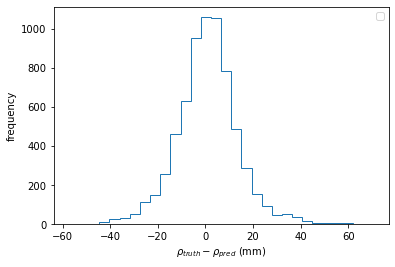

In [61]:
plt.hist(np.sqrt(y[:,0]**2+y[:,1]**2) - np.sqrt(predictions[:,0]**2+predictions[:,1]**2), histtype='step', bins=30)
plt.xlabel(r'$\rho_{truth} - \rho_{pred}$ (mm)')
plt.ylabel('frequency')
plt.legend();
#axs[1].set_yscale('log')

In [62]:
# Plot errors as a function of pT

In [63]:
from scipy.stats import binned_statistic


mean_stat = binned_statistic(pt, err, 
                             statistic='mean', 
                             bins=20, 
                             range=(min(pt), 200))

std_stat = binned_statistic(pt, err, 
                             statistic='std', 
                             bins=20, 
                             range=(min(pt), 200))

(-10.0, 200.0)

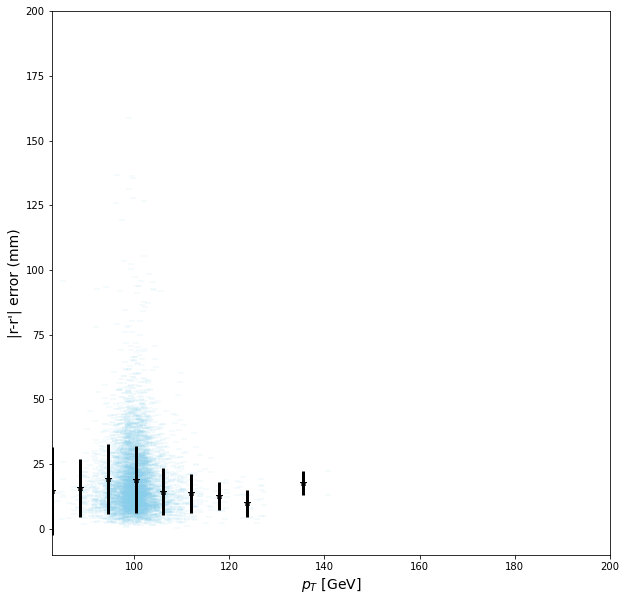

In [64]:
fig = plt.figure(figsize=(10,10))
plt.scatter(pt, err,marker='_', alpha=.1, color='skyblue')
plt.errorbar(mean_stat.bin_edges[:-1], mean_stat.statistic, yerr=std_stat.statistic, 
             fmt='*',
             color='black',
             lw=10,
            ecolor='black',
            elinewidth=3)
#plt.xscale('log')
plt.xlabel('$p_{T}$ [GeV]', fontsize=14);
plt.ylabel("|r-r'| error (mm)", fontsize=14);
plt.xlim([min(pt),200])
plt.ylim([-10, 200])
#plt.xscale('log')
#plt.title('Sum of Distance Between Predicted and True Hits per Track')
#plt.savefig('Etaefficiency.pdf')

In [124]:
def get_eta(r, z):
    # eta = -ln(tan(theta/2))
    if z == 0:
        return 0

    sign = 1
    if z < 0:
        sign = -1
        z = abs(z)
    theta = math.atan(r/float(z))
    tan_theta_over_two = math.tan(theta/2.)
    try:
        eta = -math.log( tan_theta_over_two )
    except ValueError:
        print ("can't take log of", tan_theta_over_two, 'from theta =', theta)
        sys.exit()
    return eta * sign

#find eta of the first hit in every track
eta=[]
for ii in range(len(x)):
    hitx = x[ii,0,0]*1015
    hity = x[ii,0,1]*1015
    hitz = x[ii,0,2]*3000
    hitr = np.sqrt((hitx)**2 + (hity)**2 + (hitz)**2)
    eta.append(get_eta(hitr,hitz))
    
from scipy.stats import binned_statistic

mean_stat = binned_statistic(eta, err, 
                             statistic='mean', 
                             bins=20, 
                             range=(min(eta), max(eta)))

std_stat = binned_statistic(eta, err, 
                             statistic='std', 
                             bins=20, 
                             range=(min(eta), max(eta)))

(0.0, 100.0)

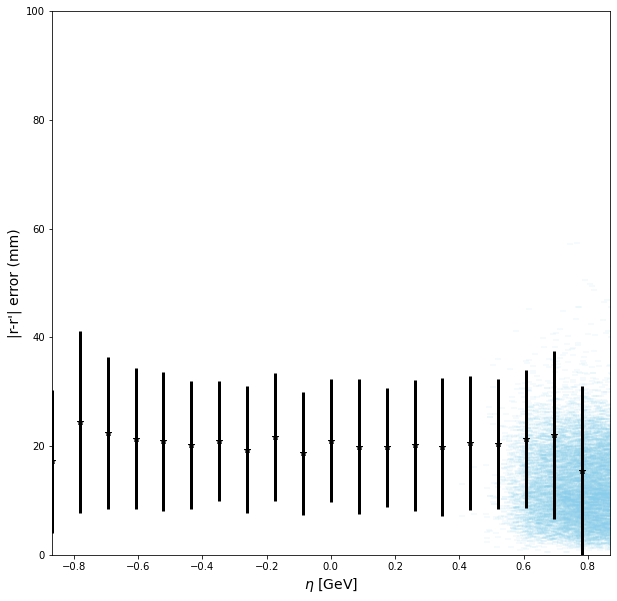

In [125]:
fig = plt.figure(figsize=(10,10))
plt.scatter(pt, err,marker='_', alpha=.1, color='skyblue')
plt.errorbar(mean_stat.bin_edges[:-1], mean_stat.statistic, yerr=std_stat.statistic, 
             fmt='*',
             color='black',
             lw=10,
            ecolor='black',
            elinewidth=3)
#plt.xscale('log')
plt.xlabel('$\eta$ [GeV]', fontsize=14);
plt.ylabel("|r-r'| error (mm)", fontsize=14);
plt.xlim([min(eta),max(eta)])
plt.ylim([-0, 100])
#plt.xscale('log')
#plt.title('Sum of Distance Between Predicted and True Hits per Track')
#plt.savefig('Etaefficiency.pdf')

(array([ 72436.,  13819.,  10577.,  14898.,  21731.,  25347.,  27179.,
         30389.,  19776., 321625.]),
 array([-8.68583676e-01, -6.94876923e-01, -5.21170169e-01, -3.47463415e-01,
        -1.73756662e-01, -4.99078769e-05,  1.73656846e-01,  3.47363600e-01,
         5.21070353e-01,  6.94777107e-01,  8.68483861e-01]),
 <BarContainer object of 10 artists>)

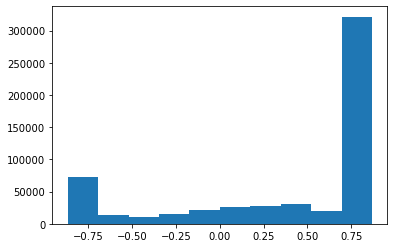

In [126]:
plt.hist(eta)